In [ ]:
# timestamp, ms elapsed, sensor, sensor, sensor
drill_data = np.genfromtxt('drive/MyDrive/Colab Data/drill/sensor_data.csv', delimiter=',')
# User#, Label, Start time, End time
df = pd.read_csv('drive/MyDrive/Colab Data/drill/label_data.csv')
df = df.replace(['C', 'W', 'M'], [1, 2, 3])
label_data = df.to_numpy()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
with open('drive/MyDrive/Colab Data/drill/prelim data/y.npy', 'rb') as f:
  data = np.flip(np.load(f), axis=0)
with open('drive/MyDrive/Colab Data/drill/prelim data/coef.npy', 'rb') as f:
  coef = np.load(f)
test = data[:,1:]
h32 = 1536.8 
h32b = 415
h21 = 1743.8
h21b = 869
poly = np.poly1d(coef)

def angles(raw_hall):
  adj_hall = np.where(raw_hall[:,2] < h32, raw_hall[:,2], np.where(raw_hall[:,2] < h21, raw_hall[:,1]+h32b, raw_hall[:,0]+h21b))
  return poly(adj_hall)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class PumpDataset(Dataset):
    """Pump dataset."""

    def __init__(self, drill_data, label_data, transform=None):
        """
        Args:
            drill_data (string): Path to the csv file with raw sensor data.
            label_data (string): Path to the csv file with labels for the sensor data.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.drill_data = np.genfromtxt(drill_data, delimiter=',')
        df = pd.read_csv(label_data)
        df = df.replace(['C', 'W', 'M'], [1, 2, 3])
        self.label_data = df.to_numpy()
        self.transform = transform

    def get_label(self, label):
      if label == 1:
        string = "C"
      elif label == 2:
        string = "W"
      elif label == 3:
        string = "M"
      else:
        string = "Wut"
      return string

    def display_data(self, sample):
      signal = sample['signal']
      label = sample['label']
      
      plt.plot(signal)
      plt.title(label)

      plt.figure()
      plt.title("fft")
      for i in range(3):
        fft = np.fft.fft(signal[:,i])
        freq = np.fft.fftfreq(signal[:,i].shape[-1])
        plt.plot(freq, np.abs(fft))
      plt.xlim([0,.5])
      plt.ylim([0,2e5])

      plt.figure()
      plt.title("copy pasta regrssion model")
      plt.plot(angles(signal))

    def __len__(self):
        return len(self.label_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        start_time = self.label_data[idx,2]
        end_time = self.label_data[idx,3]
        sensor_data = self.drill_data[np.where( (self.drill_data[:,0] > start_time) * (self.drill_data[:,0] < end_time))]
        signal = sensor_data[:,2:5]
        label = self.get_label(self.label_data[idx, 1])
        sample = {'signal': signal, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

pump_dataset = PumpDataset(drill_data='drive/MyDrive/Colab Data/drill/sensor_data.csv',
                                    label_data='drive/MyDrive/Colab Data/drill/label_data.csv')


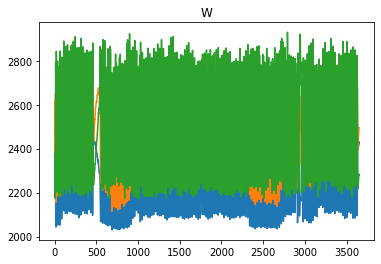

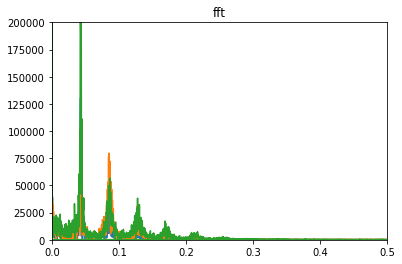

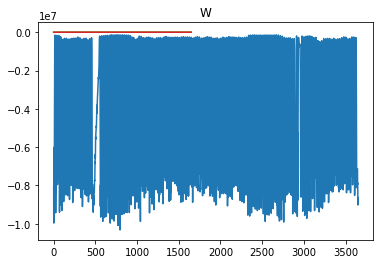

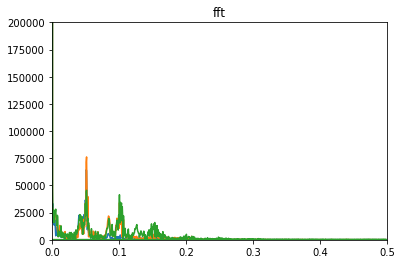

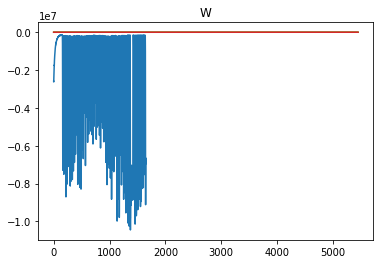

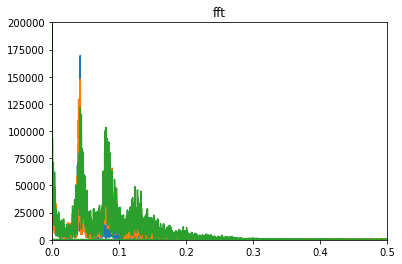

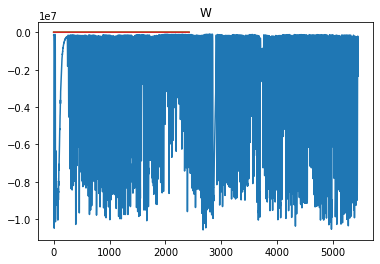

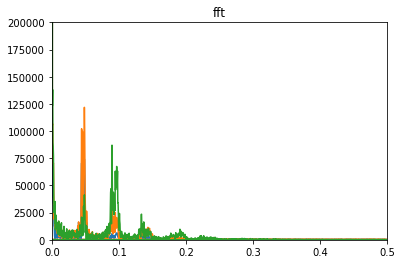

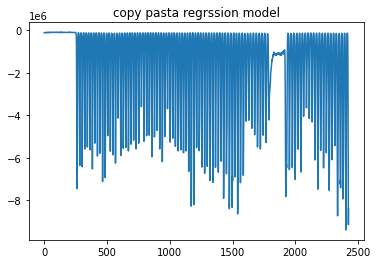

In [ ]:
for i in range(len(pump_dataset)):
    sample = pump_dataset[i]

    print(i, sample['signal'].shape, sample['label'])
    pump_dataset.display_data(sample)

    if i == 3:
        plt.show()
        break